# StyleGAN2

Open in Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/natural_language_generation/blob/main/Fake_Faces_with_StyleGAN2.ipynb)



This notebook demonstrates how to run NVIDIA's StyleGAN2 on Google Colab.
Make sure to specify a GPU runtime.

This notebook mainly adds a few convenience functions. 

For information on StyleGAN2, see:

Paper: https://arxiv.org/abs/1812.04948

Video: https://youtu.be/kSLJriaOumA

Code: https://github.com/NVlabs/stylegan

FFHQ: https://github.com/NVlabs/ffhq-dataset

Mikael Christensen, 2019.


# Setup

### Clone StyleGAN2 Repository

We will need to make sure we have the proper version of TensorFlow.  We then clone StyleGAN2 from its GitHubg repository: https://github.com/NVlabs/stylegan2.git

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 138 (delta 4), reused 4 (delta 3), pack-reused 127
Receiving objects: 100% (138/138), 599.46 KiB | 8.33 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d9739a22-6294-668d-e7d6-eba16936a0eb)
GPU Identified at: /device:GPU:0


### Import Packages

Now we import all the necessary packages.

In [ ]:
import matplotlib.pyplot as plt
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

### Choose StyleGAN Model

We download the model of choice. A complete list of pretrained models is in the code below.  These models generate many types of objects:

1. Faces

2. Cars

3. Horses

4. Churches

5. Cats

Set `model_name` equal to the chosen model. I think `"stylegan2-ffhq-config-f.pkl"` is the best choice for face generation.


In [ ]:
#Model Names
# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl

model_name = "stylegan2-ffhq-config-f.pkl"

network_pkl = f"gdrive:networks/{model_name}"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


### Helper Functions

The code below has a whole bunch of useful functions we will use.

In [ ]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dl,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow_solo(a, format='png', jpeg_fallback=True,width = 128, height = 128):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data,width=width, height=height))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





# Generate Fake Faces with StyleGAN2

Set `seeds` equal to a list of integers.  From each seed a different face will be generated by StyleGAN2.

In [ ]:
# generate some random seeds
seeds = [1,2,3,4,5,6]
print(f"Seeds = {seeds}")

imgs =generate_images_from_seeds(seeds, 0.7)


Seeds = [1, 2, 3, 4, 5, 6]


### View Individual Images

Set `image_index` equal to the integer value of the image you want to view.  You can save this image by right-clicking on it and choosing **Save Image As...**.

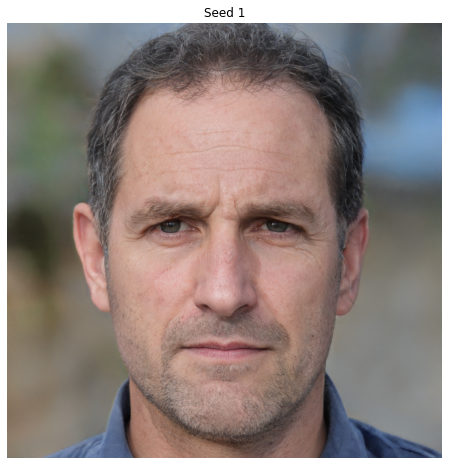

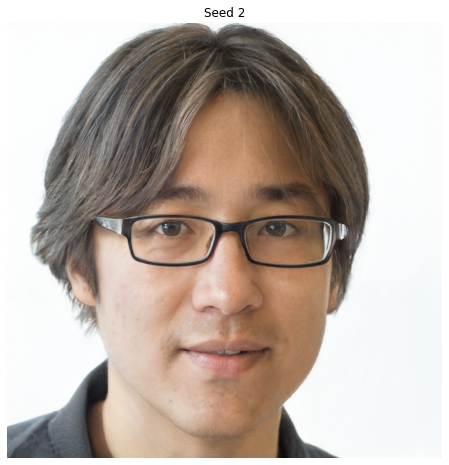

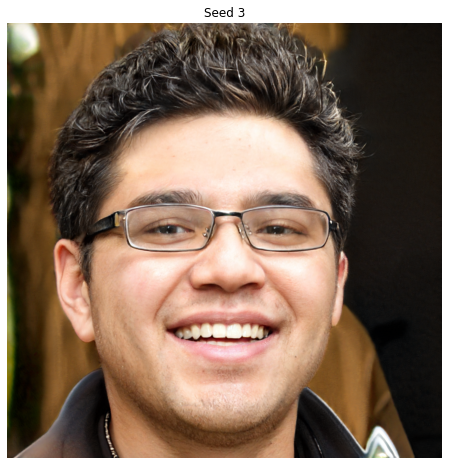

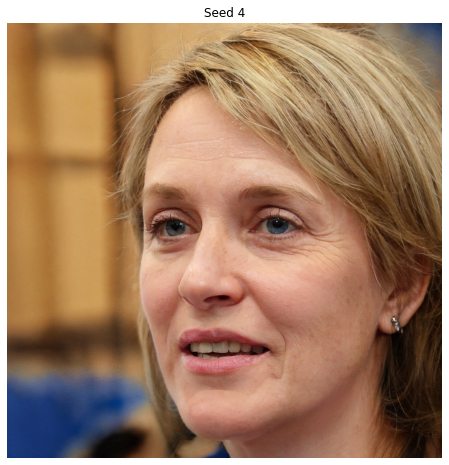

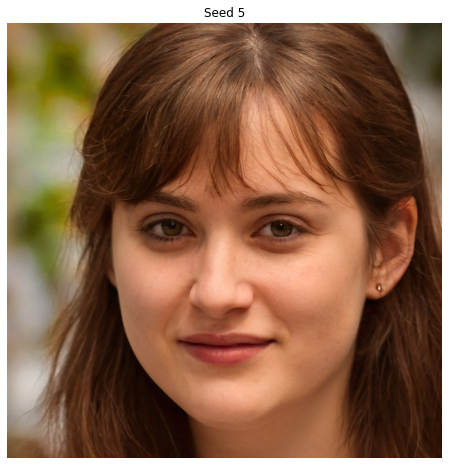

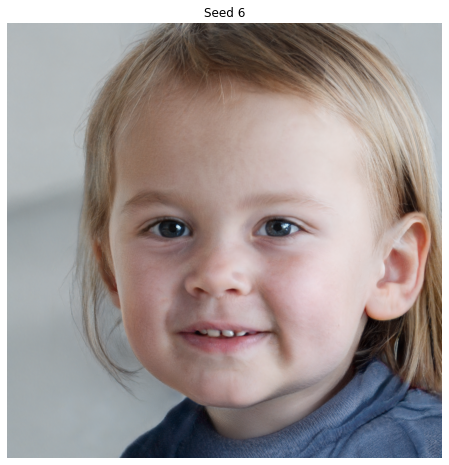

In [ ]:
for image_index in range(len(imgs)):
  fig = plt.figure(figsize = (8,8))
  plt.imshow(imgs[image_index])
  plt.axis('off')
  plt.title(f"Seed {seeds[image_index]}")
  plt.show()

# Generate Interpolation of Faces with StyleGAN2 in Z-Space


We generate random input vectors in z-space.  Pick two integers for the seed values `seed_A` and `seed_B`.  These will be used to generate the latent inputs to the StyleGAN2 model.  Then select `number_of_steps` for how many intermediate interpolated images you want to generate between the two seed images.

The image arrays are saved in `imgs_z`.


Interpolating in z-space from seed 11 to 12 with 6 steps


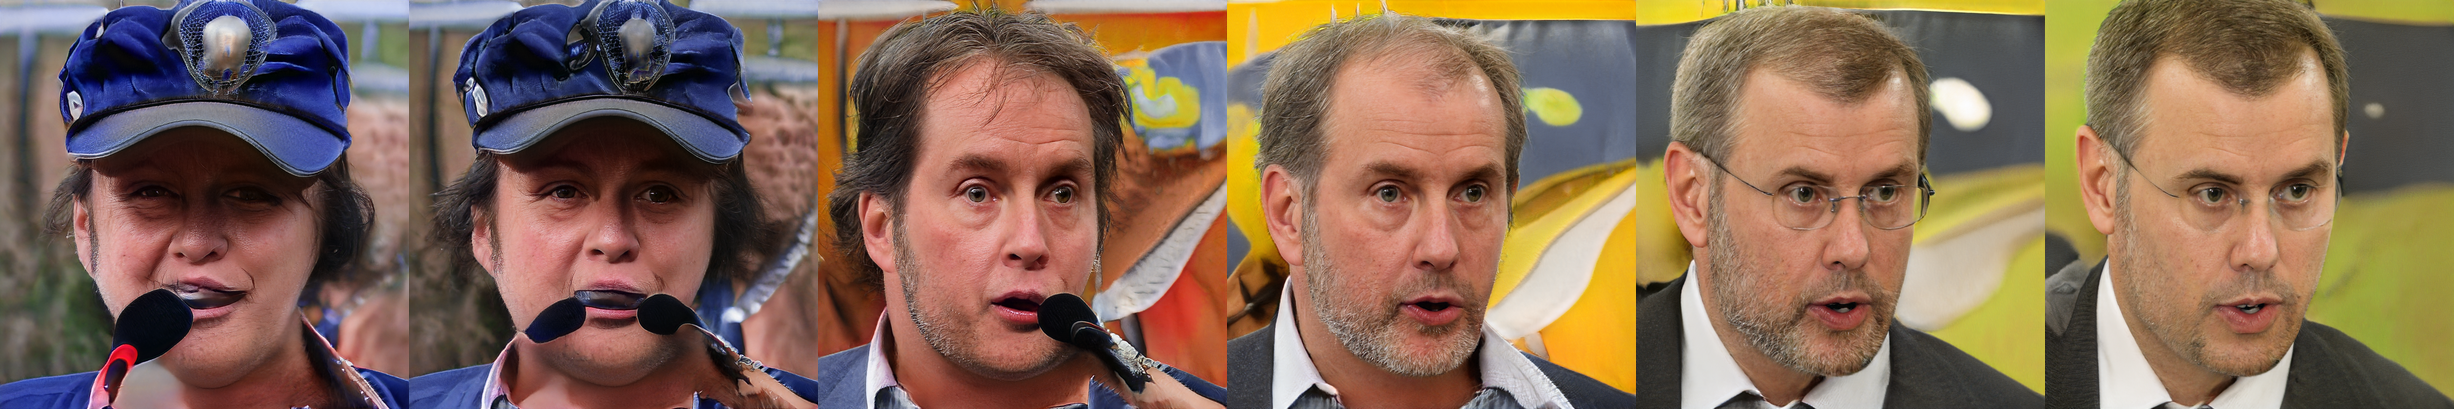

In [ ]:
# Simple (Z) interpolation
seed_A = 11
seed_B = 12
zs = generate_zs_from_seeds([seed_A , seed_B ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 6
nrows = 1  #number of rows of images to show
print(f"Interpolating in z-space from seed {seed_A} to {seed_B} with {number_of_steps} steps")
imgs_z = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
imshow(createImageGrid(imgs_z, 0.4 , nrows))

### View Individual Images

Set `image_index` equal to the integer value of the image you want to view.  You can save this image by right-clicking on it and choosing **Save Image As...**.

Z-space interpolated image 3/6


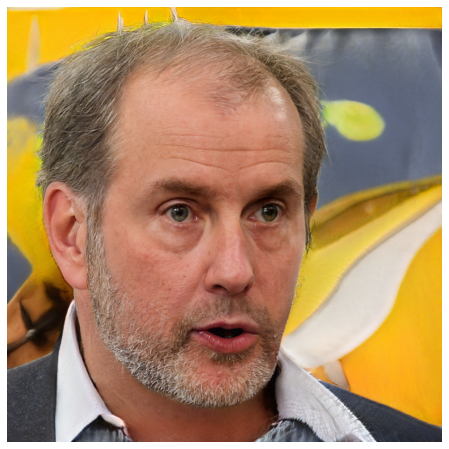

In [ ]:
image_index  = 3
print(f"Z-space interpolated image {image_index}/{number_of_steps}")
fig = plt.figure(figsize = (8,8))
plt.imshow(imgs_z[image_index])
plt.axis('off')
plt.show()

### Save Images to Movie

We can save the images as a movie showing the face transforming from the intial face to the final face.

In [ ]:
%mkdir out
movieName_z = f'out/mov_z_space_{seed_A}_to_{seed_B}_{number_of_steps}_steps.mp4'

with imageio.get_writer(movieName_z, mode='I') as writer:
    for image in log_progress(list(imgs_z), name = "Creating animation"):
        writer.append_data(np.array(image))

# Generate Interpolation of Faces with StyleGAN2 in W-Space

We generate random input vectors in w-space.  Pick two integers for the seed values `seed_A` and `seed_B`.  These will be used to generate the latent inputs to the StyleGAN2 model.  Then select `number_of_steps` for how many intermediate interpolated images you want to generate between the two seed images.

The image arrays are saved in `imgs_w`.



Interpolating in w-space from seed 11 to 12 with 6 steps


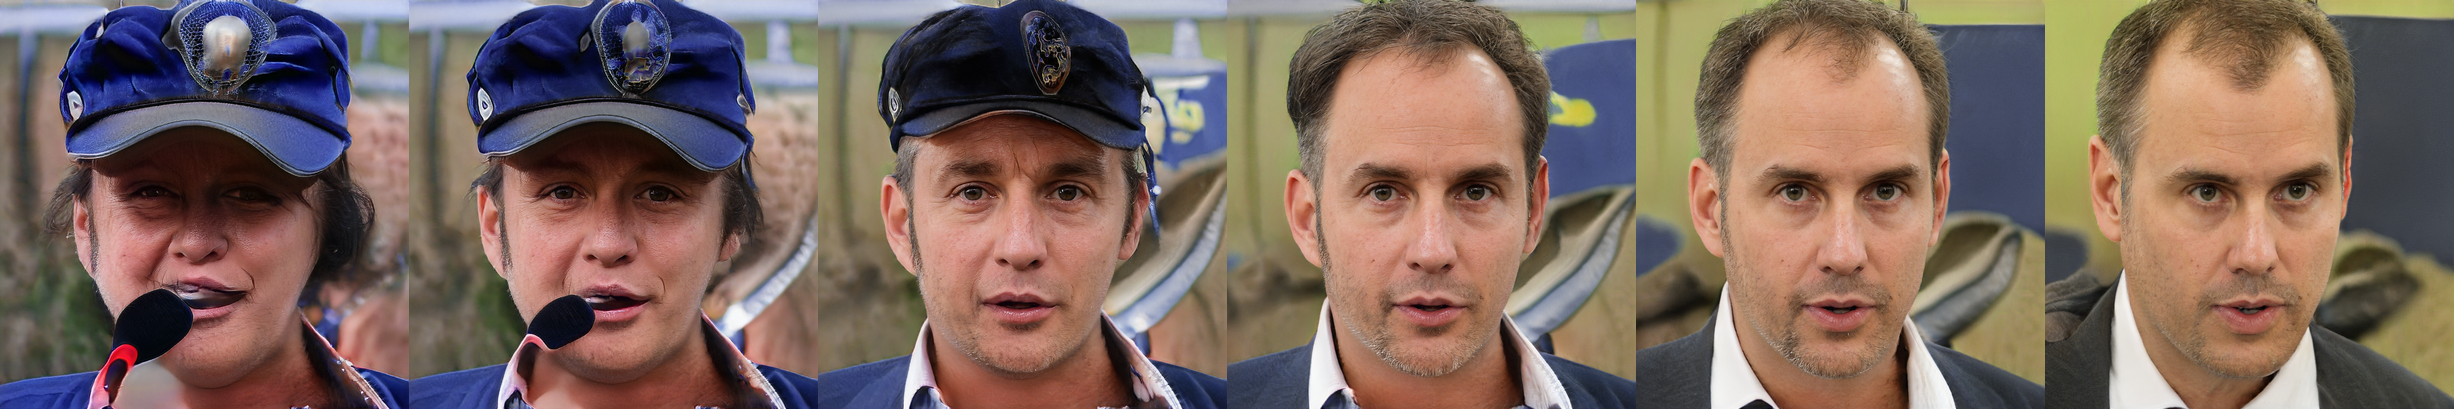

In [ ]:
seed_A = 11
seed_B = 12

zs = generate_zs_from_seeds([seed_A , seed_B ])

# It seems my truncation_psi is slightly less efficient in W space - I probably introduced an error somewhere...

dls = []
for z in zs:
  dls.append(convertZtoW(z ,truncation_psi=1.0))

number_of_steps = 6
nrows = 1
print(f"Interpolating in w-space from seed {seed_A} to {seed_B} with {number_of_steps} steps")

imgs_w = generate_images_in_w_space(interpolate(dls,number_of_steps), 1.0)
imshow(createImageGrid(imgs_w, 0.4 , nrows))



### View Individual Images

Set `image_index` equal to the integer value of the image you want to view.  You can save this image by right-clicking on it and choosing **Save Image As...**.


W-space interpolated image 3/6


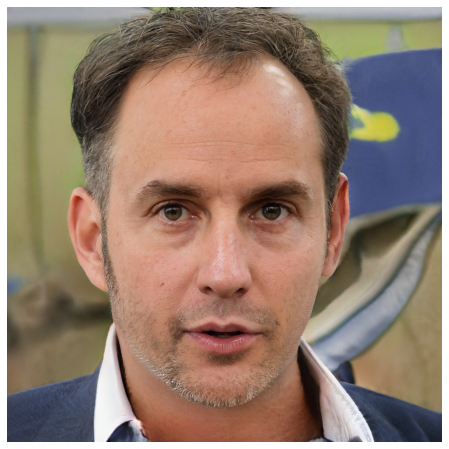

In [ ]:
image_index  = 3
print(f"W-space interpolated image {image_index}/{number_of_steps}")
fig = plt.figure(figsize = (8,8))
plt.imshow(imgs_w[image_index])
plt.axis('off')
plt.show()

### Save Images to Movie

We can save the images as a movie showing the face transforming from the intial face to the final face.

In [ ]:
%mkdir out
movieName_w = f'out/mov_w_space_{seed_A}_to_{seed_B}_{number_of_steps}_steps.mp4'

with imageio.get_writer(movieName_w, mode='I') as writer:
    for image in log_progress(list(imgs_w), name = "Creating animation"):
        writer.append_data(np.array(image))



# Tuning the Face in W-Space

We can adjust the input in W-space to have more control over the face.  The W-space noise has shape (1, 18, 512).  The 512 is the dimension of the noise, and there are 18 layers in the  synthesis network.  We will add a constant to layer 0 and see how the base image is changed.  Choose a positive integer for `seed_A` to get a base image, then choose the values you want for the layer with the array `layer_values`.  The values should be between 0 and 1.

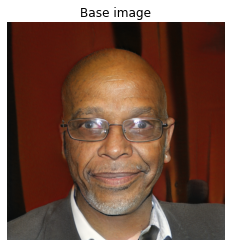

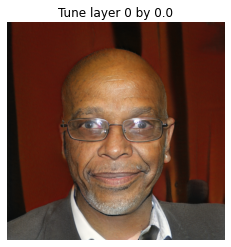

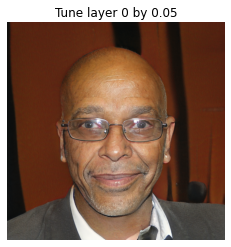

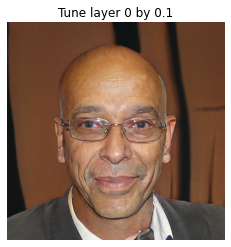

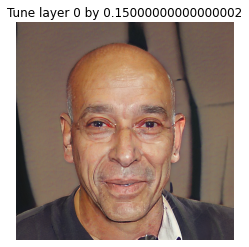

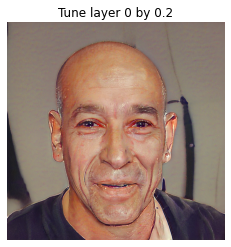

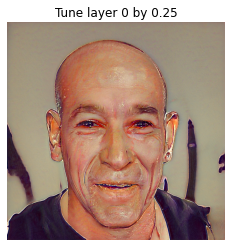

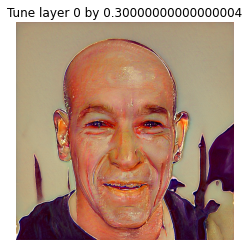

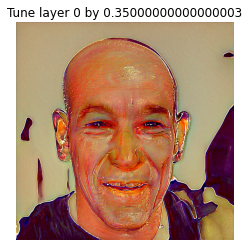

In [ ]:

layer_values = np.arange(0,0.4,0.05)
seed_A = 1703186094
layer = 0

zs = generate_zs_from_seeds([seed_A , 1 ])

dls = []
for z in zs:
  dls.append(convertZtoW(z ,truncation_psi=1.0))

number_of_steps = 30
wint = interpolate(dls,number_of_steps)
s = wint[0].shape
slayer = wint[0][:,1,:].shape
nlayers = slayer[1]  #number of layers




imgs_w = generate_images_in_w_space(wint[0:1], 1.0)
plt.imshow(imgs_w[0])
plt.axis('off')
plt.title(f"Base image")
plt.show()
count = 0
for layer_value in layer_values:
  w0 = wint
  w0[layer] =  w0[layer]+layer_value * np.ones(s) 
  imgs_w = generate_images_in_w_space(w0[0:1], 1.0)
  plt.imshow(imgs_w[0])
  plt.axis('off')
  plt.title(f"Tune layer {layer} by {layer_value}")
  plt.show()
  count+=1

